## Greedy algorithm for Jobs Scheduling Problem

Given a sequence of jobs, each has a weight `w` (priority) and a length `l`, in what order should we sequence the jobs such that the weighted sum of completion times is minimized?

In [1]:
def schedule_jobs(jobs):
    """
    input:  a sequence of jobs in a list of tuples [(weight1, length1), (weight2, length2), ...]
    output: a number "WSCT" = weighted sum of completion times,
            an optimal job sequence "SEQ" = [(job, score), (job, score), ...]
    time:   O(nlogn), just need to sort by greedy score
    """
    scores = { index:(job[0] / job[1]) for index, job in enumerate(jobs) }
    SEQ = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    cc = 0  # completion time
    WSCT = 0
    for index, score in SEQ:
        wt, lt = jobs[index]
        cc += lt
        WSCT += wt * cc
    
    return WSCT, SEQ

In [2]:
jobs = [(5,2), (2,1), (8,8), (6,4), (9,3), (12,3)]

In [3]:
scores = { index:(job[0] / job[1]) for index, job in enumerate(jobs) }
sorted(scores.items(), key=lambda x: x[1], reverse=True)

[(5, 4.0), (4, 3.0), (0, 2.5), (1, 2.0), (3, 1.5), (2, 1.0)]

In [4]:
WSCT, SEQ = schedule_jobs(jobs)
print("WSCT:", WSCT)
print("SEQ:", SEQ)

WSCT: 394
SEQ: [(5, 4.0), (4, 3.0), (0, 2.5), (1, 2.0), (3, 1.5), (2, 1.0)]


In [7]:
jobs = []
with open("support/jobs.txt", "rt") as fh:
    for line in fh.readlines():
        line = line.strip().split()
        if len(line) == 2:
            jobs.append((int(line[0]), int(line[1])))

In [8]:
WSCT, SEQ = schedule_jobs(jobs)
print("WSCT:", WSCT)

WSCT: 67311454237


## LRU Cache Algorithm - Least Recently Used Cache for Redis/operating systems

### Doubly Linked List Class

In [9]:
class Node:
    
    def __init__(self, data=None):
        self.data = data
        self.prev = None
        self.next = None

In [10]:
class DoubleLinkList:

    def __init__(self):
        self.head = Node()  # null pointer
        self.tail = Node()  # null pointer
        self.head.next = self.tail
        self.tail.prev = self.head
        self._size = 0

    @property
    def size(self):
        return self._size
        
    def __str__(self):
        curr = self.head.next
        out = "[head,"
        while curr.data != None:
            out += (str(curr.data) + ',')
            curr = curr.next
        return out + "tail]"
    
    __repr__ = __str__
    
    def __contains__(self, node):
        curr = self.head.next
        while curr.data != None:
            if id(curr) == id(node):
                return True
            curr = curr.next
        return False
        
    def append(self, node, pos="tail"):
        ''' append to the head/tail of the list, takes O(1) time '''
        if pos == "tail":
            self.tail.prev.next = node
            node.prev = self.tail.prev
            node.next = self.tail
            self.tail.prev = node
        elif pos == "head":
            node.next = self.head.next
            self.head.next.prev = node
            self.head.next = node
            node.prev = self.head
        else:
            return
        self._size += 1

    def delete(self, node):
        ''' delete the node in the list, takes O(1) time '''
        l = node.prev
        r = node.next
        l.next = r
        r.prev = l
        self._size -= 1
    
    def pop(self):
        """ remove and return the last node in the list, takes O(1) time.
            pop() should not have any arguments, otherwise it's a delete()
        """
        node = self.tail.prev
        node.prev.next = self.tail
        self.tail.prev = node.prev
        self._size -= 1
        return node
        
    def clear(self):
        return self.__init__()

In [11]:
# l1 = SingleLinkList()
l2 = DoubleLinkList()

In [12]:
for data in range(10):
    l2.append(Node(data))

In [13]:
print(l2)

[head,0,1,2,3,4,5,6,7,8,9,tail]


In [14]:
Bob = Node('Bob')
l2.append(Bob)
l2

[head,0,1,2,3,4,5,6,7,8,9,Bob,tail]

In [15]:
Alice = Node('Alice')
l2.append(Alice, pos="head")
l2

[head,Alice,0,1,2,3,4,5,6,7,8,9,Bob,tail]

In [16]:
(Alice in l2) & (Bob in l2)

True

In [17]:
l2.delete(Alice)
l2

[head,0,1,2,3,4,5,6,7,8,9,Bob,tail]

In [18]:
Alice in l2

False

In [19]:
node = l2.pop()
node.data

'Bob'

In [20]:
id(node) == id(Bob)

True

In [21]:
Bob in l2

False

In [22]:
l2

[head,0,1,2,3,4,5,6,7,8,9,tail]

In [23]:
l2.size  # head/tail are null pointers, not counted in

10

In [24]:
l2.clear()
l2

[head,tail]

### LRU Cache Class

https://leetcode.com/problems/lru-cache/

In [25]:
class LRUCache:
    '''
    for fast lookups/inserts/deletes all in O(1), use "hashmap" + "doubly linked list".
    (self._cache) is a doubly linked list which stores real data in different nodes.
    (self._hashmap) is a dictionary that maps keys to real node objects in (self._cache).
    '''
    def __init__(self, capacity):
        self._hashmap = {}
        self._cache = DoubleLinkList()
        self._capacity = capacity  # maximum # of slots
        self._size = 0
    
    @property  # read-only attribute
    def capacity(self):
        return self._capacity
    
    @property  # read-only attribute
    def size(self):
        return self._size
    
    def read(self, key):
        node = self._hashmap.get(key, None)  # O(1)
        if node and node.data:
            self._cache.delete(node)              # O(1)
            self._cache.append(node, pos="head")  # O(1)
            # if the hashmap {} maps to physical addresses of node objects,
            # also need to update the address: self._hashmap[key] = new_address
            return node.data
        else:
            return -1
    
    def write(self, key, value):
        node = self._hashmap.get(key, None)
        if node and node.data:
            self._cache.delete(node)
            node.data = value  # when attributes of the node updated, the hashmap still maps to this node
            self._cache.append(node, pos="head")
        else:
            new_node = Node(value)
            self._hashmap[key] = new_node
            
            if self._capacity <= self._size:
                last = self._cache.pop()
                # last = None  # this will make a new copy of "last", so the mapping will persist
                last.data = None  # disable the hashmap mapping to this node
                self._size -= 1
                
            self._cache.append(new_node, pos="head")
            self._size += 1
            
    def view_cache(self):
        for key, node in self._hashmap.items():
            print(key.ljust(12), ("Node(" + str(node.data) + ")").rjust(12))
        print("--------------------")
        print(self._cache)

In [26]:
cache = LRUCache(capacity=5)

In [27]:
cache.capacity  # read-only attribute, protected data

5

In [28]:
cache.size

0

In [29]:
cache.write("Alice", 99)
cache.write("Bob", 70)
cache.write("Carlos", 82)
cache.view_cache()

Carlos           Node(82)
Alice            Node(99)
Bob              Node(70)
--------------------
[head,82,70,99,tail]


In [30]:
cache.read("Jack")

-1

In [31]:
cache.read("Alice")

99

In [32]:
cache.view_cache()

Carlos           Node(82)
Alice            Node(99)
Bob              Node(70)
--------------------
[head,99,82,70,tail]


In [33]:
cache.size

3

In [34]:
cache.write("Jack", 65)
cache.write("James", 79)
cache.view_cache()

Carlos           Node(82)
Jack             Node(65)
Alice            Node(99)
Bob              Node(70)
James            Node(79)
--------------------
[head,79,65,99,82,70,tail]


In [35]:
cache.write("Sophia", 89)  # Bob: 70 will be removed
cache.view_cache()

Sophia           Node(89)
Jack             Node(65)
Carlos           Node(82)
Alice            Node(99)
James            Node(79)
Bob            Node(None)
--------------------
[head,89,79,65,99,82,tail]


In [36]:
cache.size

5

In [37]:
cache.read("Bob")

-1

In [38]:
cache.write("James", 11)  # update James's score
cache.view_cache()

Sophia           Node(89)
Jack             Node(65)
Carlos           Node(82)
Alice            Node(99)
James            Node(11)
Bob            Node(None)
--------------------
[head,11,89,65,99,82,tail]


## Prim's Minimum Spanning Trees Greedy Algorithm

In [39]:
import numpy as np
import networkx as nx
import heapq as hq
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def prim(graph):
    """
    input:  a connected undirected graph
    output: MST = minimum spanning tree, a subset of the edges collection with minimum sum of edge costs,
            MC = minimum total cost
    time:   O(m*n)
    """
    source = list(graph.keys())[0]  # randomly choose a source vertex
    X = set([source])  # keep track of all vertices visited
    T = []
    MC = 0
    
    while len(X) != len(graph):
        # choose the edge that has the lowest cost
        cost = np.inf
        edge = None
        
        for u in graph:
            for v in graph[u]:
                if u in X and v not in X:
                    if graph[u][v] < cost:
                        cost = graph[u][v]
                        edge = (u, v)
        
        if edge:
            T.append(edge)
            X.add(edge[1])
            MC += cost
    
    return T, MC

In [41]:
graph = {
    'a': {'b': 1, 'c': 4, 'd': 3},
    'b': {'a': 1, 'd': 2},
    'c': {'a': 4, 'd': 5},
    'd': {'a': 3, 'c': 5, 'b': 2}
}

In [42]:
MST, MC = prim(graph)
MST

[('c', 'a'), ('a', 'b'), ('b', 'd')]

{('b', 'a'): Text(-0.0733049,-0.472407,'1'),
 ('c', 'a'): Text(-0.337175,0.433161,'4'),
 ('c', 'd'): Text(0.0733049,0.472407,'5'),
 ('d', 'a'): Text(-0.107702,0.0944317,'3'),
 ('d', 'b'): Text(0.337175,-0.433161,'2')}

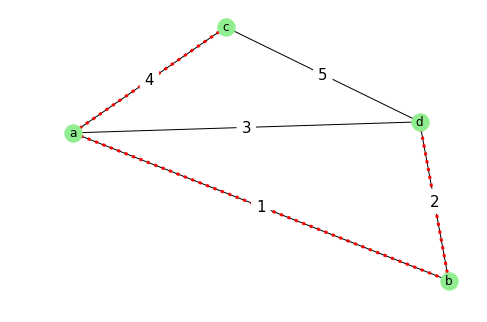

In [44]:
WG = nx.Graph()
WG.add_edge('a', 'b', weight=1)
WG.add_edge('b', 'd', weight=2)
WG.add_edge('a', 'c', weight=4)
WG.add_edge('c', 'd', weight=5)
WG.add_edge('a', 'd', weight=3)

pos = nx.fruchterman_reingold_layout(WG)
nx.draw(WG, pos=pos, with_labels=True, node_color="lightgreen")
nx.draw_networkx_edges(WG, pos, edgelist=MST, edge_color="red", style="dotted", width=3)
nx.draw_networkx_edge_labels(WG, pos, edge_labels=nx.get_edge_attributes(WG, 'weight'), font_size=15, rotate=False)

## Accelerate Prim's MST Algorithm using a min heap

Helper functions that support lookups/deletes in the heap

In [45]:
def search_node(heap, node):
    index = 0
    for item in heap:
        if item[2] == node:  # tuple[2] is the end node
            return (item[0], item[1], item[2], index)
        index += 1
    return

def remove_node(heap, node):
    _, _, _, index = search_node(heap, node)  # 1.find the node's position in the list
    heap[index] = heap[-1]                    # 2.swap with the last element
    heap.pop()                                # 3.remove the last element (list.pop())
    hq.heapify(heap)                          # 4.rearrange the heap

In [56]:
def prim_heap(graph):
    """
    input:  a connected undirected graph
    output: MST = minimum spanning tree, a subset of the edges collection with minimum sum of edge costs,
            MC = minimum total cost
    time:   O(m*logn), in each greedy step we extract-min from the heap, which takes O(logn) = O(logm)
    """
    source = list(graph.keys())[0]  # randomly choose a source vertex
    X = set([source])  # keep track of all vertices visited
    T = []
    MC = 0
    
    H = []  # initialize the heap V - X
    for w in [w for w in graph if w not in X]:  # run local tournament for each node w in V - X
        min_cost = np.inf
        winner = None
        
        for v in graph:
            if v in X and w in graph[v]:
                cost = graph[v][w]
                
                if cost < min_cost:
                    min_cost = cost
                    winner = (v, w)
                        
        if winner:
            v, w = winner
            hq.heappush(H, (min_cost, v, w))  # "w" is unique across the heap
        else:
            hq.heappush(H, (np.inf, None, w))  # for isolated nodes, key = infinity
    
    assert len(H) == (len(graph) - len(X)), "Incorrect heap size!"
    
    while H:
        cost, v, w = hq.heappop(H)  # extract-min from the heap 1 by 1, and add to X
        X.add(w)
        T.append((v, w))
        MC += cost

        for t in graph[w]:  # update keys for nodes in graph[w]
            if t not in X:
                new_cost = graph[w][t]
                cost, _, _, _ = search_node(H, t)
                
                if new_cost < cost:
                    remove_node(H, t)
                    hq.heappush(H, (new_cost, w, t))
                    
    return T, MC

In [57]:
graph = {}  # the undirected graph must be symmetric!

with open("support/edges.txt", "rt") as fh:
    for line in fh.readlines():
        line = line.strip().split()
        
        if len(line) == 3:
            u, v, cost = [int(i) for i in line]
            
            if u not in graph:
                graph[u] = {v: cost}
            else:
                graph[u][v] = cost
                
            if v not in graph:
                graph[v] = {u: cost}
            else:
                graph[v][u] = cost

In [58]:
graph[316]  # test

{1: 569, 51: -1958, 90: -4576, 315: 7783, 317: -7213, 462: 3135, 476: -6467}

In [59]:
%%timeit
MST, MC = prim(graph)

163 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
MC

-3612829

In [61]:
%%timeit
MST, MC = prim_heap(graph)

85.9 ms ± 426 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
MC

-3612829

## Advanced Union-Find for handling disjoint sets

Need to design the data structure like binary search trees.

`find()`: with path compression, update parent in each run, save time for the next call  
`union()`: lazy union, update parent only for 1 node, union by rank  

For Advanced Union-Find, all operations = nearly constant time = `O(log*(n))`, where `log*(n)` is the number of log() operations required to make n down to <= 1. For practical values of n, `log*(n) ≤ 5`.

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pygraphviz
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [48]:
class UnionFind:

    def __init__(self, nodes):
        self.parent = {v:v for v in nodes}
        self.rank = {v:0 for v in nodes}
        self._size = len(nodes)  # number of clusters in Union-Find
        
    @property
    def size(self):
        return self._size
    
    def __str__(self):
        out = "number of clusters: " + str(self.size) + "\n"
        out += ("all parents: " + str(set(self.parent.values())) + "\n")
        for v, p in self.parent.items():
            out += ("parent(" + str(v) + "): " + str(p) + "\n")
        return out
            
    __repr__ = __str__
        
    def find(self, v):
        ''' worst case O(logn)-time '''
        if self.parent[v] == v:
            return v
        self.parent[v] = self.find(self.parent[v])  # path compression
        return self.parent[v]
    
    def union(self, u, v):
        ''' worst case O(logn)-time '''
        if u == v:
            return
        pu, pv = self.find(u), self.find(v)
        ru, rv = self.rank[pu], self.rank[pv]
        if pu == pv:
            print(u, "and", v, "are already unioned!")
            return
        if ru <= rv:
            self.parent[pu] = pv
        else:
            self.parent[pv] = pu
        if ru == rv:
            self.rank[pv] += 1
        self._size -= 1

In [7]:
UF = UnionFind(range(10))
UF

number of clusters: 10
all parents: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
parent(0): 0
parent(1): 1
parent(2): 2
parent(3): 3
parent(4): 4
parent(5): 5
parent(6): 6
parent(7): 7
parent(8): 8
parent(9): 9

In [8]:
UF.union(3, 4)
UF

number of clusters: 9
all parents: {0, 1, 2, 4, 5, 6, 7, 8, 9}
parent(0): 0
parent(1): 1
parent(2): 2
parent(3): 4
parent(4): 4
parent(5): 5
parent(6): 6
parent(7): 7
parent(8): 8
parent(9): 9

In [9]:
UF.union(4, 9)  # {4,3} is the big tree, {9} is the small tree
UF

number of clusters: 8
all parents: {0, 1, 2, 4, 5, 6, 7, 8}
parent(0): 0
parent(1): 1
parent(2): 2
parent(3): 4
parent(4): 4
parent(5): 5
parent(6): 6
parent(7): 7
parent(8): 8
parent(9): 4

In [10]:
UF.union(4, 9)

4 and 9 are already unioned!


In [11]:
for i in range(10):
    print(UF.find(i), end=" ")

0 1 2 4 4 5 6 7 8 4 

In [12]:
UF.size

8

In [13]:
for u, v in [(5,9),(7,3),(4,8),(6,1)]:
    UF.union(u, v)

For easy visualization, let's plot:

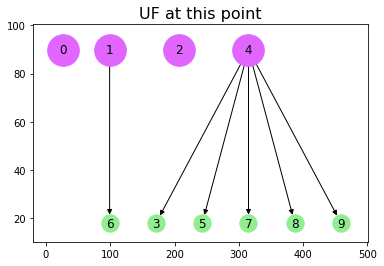

In [94]:
G = nx.DiGraph({4:[3,5,7,8,9], 1:[6], 0:[], 2:[]})
plt.title('UF at this point', fontsize=16)
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos, with_labels=True, arrows=True, node_color="lightgreen")
nx.draw_networkx_nodes(G, pos, nodelist=[0,1,2,4], node_color="#E066FF", node_size=1000)

In [16]:
UF

number of clusters: 4
all parents: {0, 1, 2, 4}
parent(0): 0
parent(1): 1
parent(2): 2
parent(3): 4
parent(4): 4
parent(5): 4
parent(6): 1
parent(7): 4
parent(8): 4
parent(9): 4

In [17]:
UF.find(8)

4

In [18]:
for u, v in [(6,0),(2,1),(5,6)]:
    UF.union(u, v)

In [19]:
UF.size

1

In [20]:
UF

number of clusters: 1
all parents: {1, 4}
parent(0): 1
parent(1): 1
parent(2): 1
parent(3): 4
parent(4): 1
parent(5): 4
parent(6): 1
parent(7): 4
parent(8): 4
parent(9): 4

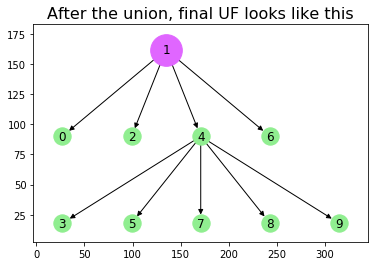

In [96]:
G = nx.DiGraph({4:[3,5,7,8,9], 1:[0,2,4,6]})
plt.title('After the union, final UF looks like this', fontsize=16)
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos, with_labels=True, arrows=True, node_color="lightgreen")
nx.draw_networkx_nodes(G, pos, nodelist=[1], node_color="#E066FF", node_size=1000)

In [92]:
UF.rank  # rank(v) = the maximum distance from v to a leaf

{0: 0, 1: 2, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

## Kruskal's MST Algorithm using Advanced Union-Find

In [97]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
G = {
    'a': {'b': 1, 'c': 7},
    'b': {'a': 1, 'c': 5, 'd': 4, 'e': 3},
    'c': {'a': 7, 'b': 5, 'e': 6},
    'd': {'b': 4, 'e': 2},
    'e': {'b': 3, 'c': 6, 'd': 2}
}

In [49]:
def kruskal(G):
    """
    input:  a connected undirected graph
    output: MST = minimum spanning tree, MC = minimum total cost
    time:   O(m*alpha(n)), where alpha(n) is the inverse Ackerman function
    """
    T = set()
    E = [(u,v,G[u][v]) for u in G for v in G[u]]
    MC = 0
    
    E = sorted(E, key=lambda x: x[2])  # sort edges in order of increasing cost
    UF = UnionFind(list(G.keys()))
    
    for u, v, cost in E:
        if UF.find(u) != UF.find(v):  # if u & v already connected, union (u,v) will make a cycle
            T.add((u, v))
            UF.union(u, v)
            MC += cost
            
    return T, MC

In [100]:
MST, MC = kruskal(G)
MST

{('a', 'b'), ('b', 'c'), ('e', 'b'), ('e', 'd')}

In [101]:
MC

11

In [102]:
E = [('a','b',1),('a','c',7),('b','c',5),('b','d',4),('c','e',6),('d','e',2),('b','e',3)]
WG = nx.Graph()
for u, v, w in E:
    WG.add_edge(u, v, weight=w)

{('a', 'b'): Text(0.2919,0.375329,'1'),
 ('a', 'c'): Text(0.656184,0.35077,'7'),
 ('b', 'c'): Text(0.0685092,0.113254,'5'),
 ('b', 'd'): Text(-0.647887,-0.0991639,'4'),
 ('e', 'b'): Text(-0.156184,-0.1827,'3'),
 ('e', 'c'): Text(0.2081,-0.207258,'6'),
 ('e', 'd'): Text(-0.508297,-0.419677,'2')}

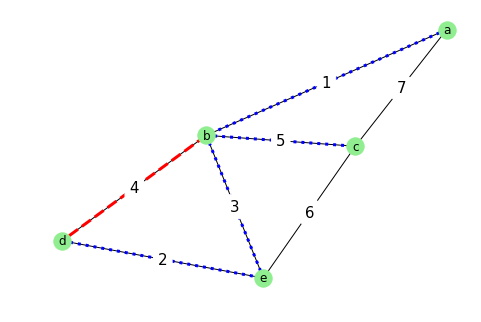

In [127]:
pos = nx.fruchterman_reingold_layout(WG)
edgelist = [('a','b'),('b','c'),('b','e'),('d','e')]
nx.draw(WG, pos=pos, with_labels=True, node_color="lightgreen")
nx.draw_networkx_edges(WG, pos, edgelist=edgelist, edge_color="blue", style="dotted", width=3)
nx.draw_networkx_edges(WG, pos, edgelist=[('b','d')], edge_color="red", style="dashed", width=3)
nx.draw_networkx_edge_labels(WG, pos, edge_labels=nx.get_edge_attributes(WG, 'weight'), font_size=15, rotate=False)

In [50]:
graph = {}  # the undirected graph must be symmetric!

with open("support/edges.txt", "rt") as fh:
    for line in fh.readlines():
        line = line.strip().split()
        
        if len(line) == 3:
            u, v, cost = [int(i) for i in line]
            
            if u not in graph:
                graph[u] = {v: cost}
            else:
                graph[u][v] = cost
                
            if v not in graph:
                graph[v] = {u: cost}
            else:
                graph[v][u] = cost

In [51]:
MST, MC = kruskal(graph)

In [52]:
MC  # -3612829

-3612829

Congratulations~! this result is exactly the same as we computed previously, correctness proved!  
In theory, __Kruskal's + Union-Find__ is as fast as __Prim's + Min-Heap__.

## Greedy Max-spacing k-clustering using Advanced Union-Find

In [128]:
G = {}
with open("support/clustering1.txt", "rt") as fh:  # make sure G is symmetric
    for line in fh.readlines():
        line = line.strip().split()
        if len(line) == 3:
            u, v, d = [int(i) for i in line]
            if u in G:
                G[u][v] = d
            else:
                G[u] = {v:d}
            if v in G:
                G[v][u] = d
            else:
                G[v] = {u:d}

In [129]:
def k_cluster(G):
    '''
    input:  a weighted graph where weight is the Euclidean distance between 2 nodes
    output: the minimum spacing between clusters after k-clustering
    '''
    E = [(u,v,G[u][v]) for u in G for v in G[u]]
    E = sorted(E, key=lambda x: x[2])  # sort by increasing distances
    UF = UnionFind(list(G.keys()))
    
    for u, v, d in E:
        if UF.find(u) == UF.find(v):
            continue
        if UF.size > 4:
            UF.union(u, v)
        else:
            return d

In [130]:
MMS = k_cluster(G)
MMS

106

## Huffman codes

In [126]:
import heapq as hq

def huffman(charset, freq):
    """
    input:  a character set such as ['A','B','C','D','E'] where chars in the set are distinct,
            a list of frequencies for each char such as [80, 50, 40, 60, 10].
    output: an optimal dict of variable-length binary codes that minimizes the average encoding length,
            the output encodings are ensured to be prefix-free, there's no ambiguity when decode.
            note that the optimal solution is not unique, this function returns only one of them.
    time:   O(nlogn) if using a heap to extract-min, or O(n) if using two queues(non-trivial)
    
    remark: the min-heap H is a list of tuples, such as [(12,['A']), (5,['B','C']), ...],
            inside the tuple, we use a list ['A','B','C', ...] to store characters in the charset.
            but why bother using a list inside the tuple? why not use (12,'A'), (5,'BCD'), etc?
            well, of course you can just concatenate characters this way, but then, this function
            would only work for single-digit charset like ['0','1',...] and single-char English charset
            such as ['a','b','c',...], but it would fail for multi-digits or multi-chars charset such
            as ['0','10','200'], ['Aa','b','CDe'], obviously, it would also fail for non-English
            charsets like ['哈','夫','曼','码'] or ['ハ','フ','マ','ン'], for example.
    """
    T = {char:'' for char in charset}
    H = list(zip(freq, [[char] for char in charset]))
    hq.heapify(H)

    while len(H) > 1:
        f1, char1 = hq.heappop(H)
        f2, char2 = hq.heappop(H)
        hq.heappush(H, (f1 + f2, char1 + char2))
        for char in char1:
            T[char] = '0' + T[char]
        for char in char2:
            T[char] = '1' + T[char]
    return T

In [127]:
huffman(['A','B','C','D','E','F'], [3,2,6,8,2,6])

{'A': '100', 'B': '1010', 'C': '00', 'D': '11', 'E': '1011', 'F': '01'}

### compress/unzip and encode/decode personal data

In [128]:
def huffman_encode(data, encoding):
    ''' mask human-readable data as binary codes 0/1 '''
    mask = ''
    for char in data:
        mask += encoding[char]
    return mask

def huffman_decode(data, encoding):
    ''' translate binary codes into strings based on encoding '''
    translate = {v: k for k, v in encoding.items()}
    unmask = ''
    curr_code = ''
    for digit in data:
        curr_code += digit
        if curr_code in translate:
            unmask += translate[curr_code]
            curr_code = ''
    return unmask

In [129]:
import string
import numpy as np

In [130]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [131]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [132]:
string.digits

'0123456789'

In [133]:
valid_chars = string.punctuation + string.ascii_letters + string.digits
valid_chars

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

In [134]:
charset = [' ', '\n']
for char in valid_chars:
    charset.append(char)

In [135]:
print(charset)

[' ', '\n', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [136]:
freq = np.random.randint(0, 1000, size=len(charset))
freq

array([680, 162, 282, 650, 168, 722, 765, 937, 225, 308, 130, 205, 700,
       890, 114, 533, 367,  90, 818, 324, 167, 702, 720,  75, 283, 671,
       838, 167, 613, 876, 825, 388, 501, 778, 511, 498, 161, 450,  65,
       254, 710, 195, 186, 275, 554, 998, 172, 180, 331, 523, 986, 142,
       330, 859, 351, 251,  87, 555, 970, 424, 100, 944, 425, 878, 210,
       497, 162, 751, 618, 766, 751, 269, 803, 157, 672, 472, 858, 693,
       915, 133, 570, 930, 398, 599, 942, 880, 185,  49, 970, 950, 851,
       130, 846, 974, 782, 501])

In [137]:
encoding = huffman(charset, freq)
encoding

{'\n': '00110100',
 ' ': '010011',
 '!': '0001110',
 '"': '001110',
 '#': '01000011',
 '$': '011010',
 '%': '011110',
 '&': '110100',
 "'": '11000110',
 '(': '0011000',
 ')': '00001000',
 '*': '10010010',
 '+': '010101',
 ',': '110000',
 '-': '110001110',
 '.': '000011',
 '/': '0110110',
 '0': '01101110',
 '1': '1100011110',
 '2': '111001',
 '3': '110111',
 '4': '101010',
 '5': '00001001',
 '6': '101000',
 '7': '111011',
 '8': '100010',
 '9': '1111101',
 ':': '100000000',
 ';': '100101',
 '<': '0011011',
 '=': '00111101',
 '>': '010110',
 '?': '011001',
 '@': '001101010',
 'A': '100000001',
 'B': '110110',
 'C': '1010011',
 'D': '101110',
 'E': '10010011',
 'F': '1110001',
 'G': '00111100',
 'H': '011100',
 'I': '001011',
 'J': '011111',
 'K': '011101',
 'L': '0000101',
 'M': '100011',
 'N': '00110010',
 'O': '010010',
 'P': '1110000',
 'Q': '101011',
 'R': '010100',
 'S': '110010',
 'T': '00010000',
 'U': '001000',
 'V': '110011',
 'W': '1001000',
 'X': '001001',
 'Y': '110101',
 'Z':

__text source__: https://en.wikipedia.org/wiki/Huffman_coding

In [138]:
text = '''
In computer science, a Huffman code is a particular type of optimal prefix code that is commonly used for lossless data compression. The process of finding and/or using such a code proceeds by means of Huffman coding, an algorithm developed by David A. Huffman while he was a Sc.D. student at MIT, and published in the 1952 paper "A Method for the Construction of Minimum-Redundancy Codes". The output from Huffman's algorithm can be viewed as a variable-length code table for encoding a source symbol. The algorithm derives this table from the estimated probability or frequency of occurrence (weight) for each possible value of the source symbol. However, although optimal among methods encoding symbols separately, Huffman coding is not always optimal among all compression methods.
'''

In [139]:
masked_data = huffman_encode(text, encoding)
masked_data

'001101000010110101111101001100110011010000001011110000001010111010110011000111110001000101001100111110011001101101111110001111101011111001100111100011111110000010011000000010011011100010111011111111111111110101111000000001011111010011001100110100000110001011000111110100110110111100111110100110000000100110000010000000001000110110001101111001100110101110111101000000000100010100111011001110100000011100011111010011010000011111111010011010000000000110110001101111010111100000001111010100110000010001000111000111111111111101101111000110010011001100110100000110001011000111110100111011001000000100000010110001001101101111001111101001100110011010000001011110010111100100000010111111111011110100100110101110001111111000111111100010010011111111110100000000100010100111111010100000001111100111111111011100011111001111100111110100111100010000000101100000000010011001100110100000010111100000010001000111000111110011111001111101101111010000001011111000011010011000100001000000111000111110100110000010001000101

In [140]:
original_data = huffman_decode(masked_data, encoding)
print(original_data)


In computer science, a Huffman code is a particular type of optimal prefix code that is commonly used for lossless data compression. The process of finding and/or using such a code proceeds by means of Huffman coding, an algorithm developed by David A. Huffman while he was a Sc.D. student at MIT, and published in the 1952 paper "A Method for the Construction of Minimum-Redundancy Codes". The output from Huffman's algorithm can be viewed as a variable-length code table for encoding a source symbol. The algorithm derives this table from the estimated probability or frequency of occurrence (weight) for each possible value of the source symbol. However, although optimal among methods encoding symbols separately, Huffman coding is not always optimal among all compression methods.



### trial test on Chinese character sets

In [142]:
charset = ['怎','样','证','明','该','三','次','有','理','数','系','函','的','值','不','可','能','都','是','素']
freq = np.random.randint(0, 100, len(charset))

In [145]:
encoding = huffman(charset, freq)
encoding

{'三': '01010',
 '不': '011000',
 '值': '1100',
 '函': '1101',
 '可': '000',
 '怎': '101000',
 '数': '01011',
 '明': '01101',
 '是': '011001',
 '有': '0100',
 '样': '1110',
 '次': '0010',
 '理': '1001',
 '的': '10101',
 '系': '0111',
 '素': '1000',
 '能': '1111',
 '证': '1011',
 '该': '0011',
 '都': '101001'}

In [146]:
text = '怎样证明该三次有理数系数函数的值不可能都是素数'

In [147]:
masked_data = huffman_encode(text, encoding)
masked_data

'1010001110101101101001101010001001001001010110111010111101010111010111000110000001111101001011001100001011'

In [148]:
original_data = huffman_decode(masked_data, encoding)
print(original_data)

怎样证明该三次有理数系数函数的值不可能都是素数


### Solution for the programming assignment

In [149]:
freq = []
with open("support/huffman.txt") as fh:
    for line in fh.readlines():
        freq.append(int(line.strip()))

In [150]:
n = freq.pop(0)

In [151]:
charset = [str(i) for i in range(n)]  # build a charset of size n

In [152]:
encoding = huffman(charset, freq)
encoding_length = [len(code) for code in encoding.values()]

In [153]:
max(encoding_length)

19

In [154]:
min(encoding_length)

9

## DP - WIS in path graphs

In [131]:
def wis(path):
    """
    input:  weights of the vertices in a path graph stored in a list,
            weights are listed in the order in which vertices appear in the path.
    output: WIS - maximum-weight independent set, W - maximum weight
    remark: here we find WIS = IS[1], because every step only depends on the previous 2 states,
            but this shortcut does not work in general, a step often depends on many past states.
            in common, to construct the optimal set in DP, we need to trace back the path in reverse order.
    """
    # initialize
    if path[0] >= path[1]:
        MW = [path[0], path[0]]
        IS = [[1], [1]]
    else:
        MW = [path[0], path[1]]  # max weight at every index
        IS = [[1], [2]]          # optimal independent set at the previous 2 indices
    
    for i in range(2, len(path)):
        if MW[i - 1] >= MW[i - 2] + path[i]:
            MW.append(MW[i - 1])
            IS[0] = IS[1]  # the (i+1)-th vertex not in WIS
        else:
            MW.append(MW[i - 2] + path[i])
            prev = IS[1]
            IS[1] = IS[0] + [i + 1]  # the (i+1)-th vertex in WIS
            IS[0] = prev
            
    return IS[1], MW[-1]

In [132]:
path = []
with open("support/mwis.txt", "rt") as fh:
    for line in fh.readlines():
        line = line.strip()
        path.append(int(line))
path.pop(0)

1000

In [133]:
WIS, W = wis(path)

In [134]:
WIS[:20]

[1, 3, 5, 8, 10, 13, 15, 18, 20, 22, 24, 26, 28, 31, 33, 36, 38, 40, 42, 44]

In [135]:
W  # 2955353732

2955353732

In [136]:
ans = ""
for num in [1, 2, 3, 4, 17, 117, 517, 997]:
    ans += str(1 if num in WIS else 0)

In [137]:
print(ans)  # 10100110

10100110


## DP - The Knapsack Problem (discrete, without repetitions)

Here we are talking about the discrete knapsack problem without repetitions.  
For fractional knapsack problem, simple greedy algorithm works fine.  

### DP implementation for medium size dataset

In [1]:
import numpy as np

In [11]:
def knapsack(items, W):
    """
    input:  items = [(v1, w1), (v2, w2), ...], the k-th item has value "vk" and weight "wk",
            W = capacity of the knapsack
    output: the optimal subset of items, and the maximum value of that set
    time:   O(n*W)
    """
    n = len(items)
    A = np.zeros((W + 1, n + 1), dtype=int)
    S = set()
    
    # 1. by recurrence, find the maximum value at each (row, col) position
    for w in range(1, W + 1):
        for i in range(1, n + 1):
            item_i = items[i - 1]  # i-th item (1-indexed)
            v_i, w_i = item_i[0], item_i[1]

            if w - w_i < 0:  # i-th item overweight
                A[w, i] = A[w, i - 1]
            elif A[w, i - 1] >= A[w - w_i, i - 1] + v_i:  # item_i not in S
                A[w, i] = A[w, i - 1]
            else:  # item_i in S
                A[w, i] = A[w - w_i, i - 1] + v_i

    # 2. from the lowest rightmost position, trace back the matrix to find the optimal S
    row, col = W, n
    while A[row, col] > 0:
        v, w = items[col - 1]
        c1 = A[row, col - 1]  # case1: inherited from the left position, itm not in S
        if row < w:  # prevent overweight
            c2 = 0
        else:
            c2 = A[row - w, col - 1] + v  # case2: derived by adding itm to S
            
        if c1 >= c2:
            col -= 1
        else:
            S.add(col)  # 1-base-indexed items
            row -= w
            col -= 1
            
    print(A)  # for debugging
    
    return S, A[W, n]  # lowest rightmost element

In [3]:
items = [(3,4),(2,3),(4,2),(4,3)]
W = 6

In [4]:
S, value = knapsack(items, W)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 4 4]
 [0 0 2 4 4]
 [0 3 3 4 4]
 [0 3 3 6 8]
 [0 3 3 7 8]]


In [5]:
S  # optimal subset = {item3, item4}

{3, 4}

In [6]:
value  # optimal value = 8

8

In [12]:
items = []
with open("support/knapsack1.txt", "rt") as fh:
    for line in fh.readlines():
        line = line.strip().split()
        value, weight = int(line[0]), int(line[1])
        items.append((value, weight))

In [13]:
W, n = items.pop(0)  # W = 10000, n = 100

In [14]:
S, value = knapsack(items, W)

In [15]:
value  # 2493893

2493893

__WARNING__: unit test should be followed by stress test  

it is extremely important to run the __STRESS TEST__ for your function. Even if you get the correct answer for the homework with your algorithm, it could still be wrong! For a variety of random inputs, please always test your function against the brute-force benchmark before moving to production.

In [16]:
items = [(1,1), (2,2), (3,3), (4,4), (5,5), (5,5), (7,7), (7,7), (8,8), (10,10), (12,12), (19,19), (25,25)]

In [17]:
S, value = knapsack(items, 36)
print(S)  # {2, 3, 4, 5, 7, 8, 9}
print(value)  # 36

{2, 3, 4, 5, 7, 8, 9}
36


### Recursive implementation for very large dataset

In [33]:
def knapsack_recursive(items, i, w):
    """ the previous iterative version takes O(n*W)-time using dynamic programming,
        but for large n and W, the recursive version with memoization is much faster.
        this is because, the recursive running time is independent of W.
    
        if recurse without memoization, running time ~ O(2^n), exponential growth.
        if recurse with memoization, running time ~ O(n^2)?, quadratic growth.
    """
    M = {}  # use a hash table for memoization, use tuple(i,w) as the key
    
    def recurse(items, i, w):
        ''' A[w,i] = max(case1, case2 + v_i) = max(A[w,i-1], A[w-w_i,i-1] + v_i)
        '''
        nonlocal M
        
        if i == 0 or w <= 0:  # base case
            M[(i, w)] = 0
            return M[(i, w)]
        
        item_i = items[i - 1]
        v_i, w_i = item_i
        
        if (i - 1, w) not in M:  # case1
            M[(i - 1, w)] = recurse(items, i - 1, w)
        
        if (i - 1, w - w_i) not in M:  # case2
            M[(i - 1, w - w_i)] = recurse(items, i - 1, w - w_i)
        
        if w - w_i < 0:  # corner case: if overweight, must choose case1
            M[(i, w)] = M[(i - 1, w)]
        else:
            M[(i, w)] = max(M[(i - 1, w)], M[(i - 1, w - w_i)] + v_i)
        
        return M[(i, w)]
    
    return recurse(items, i, w)

In [34]:
items = []
with open("support/knapsack_big.txt", "rt") as fh:
    for line in fh.readlines():
        line = line.strip().split()
        value, weight = int(line[0]), int(line[1])
        items.append((value, weight))

In [35]:
W, n = items.pop(0)  # W = 2000000, n = 2000, NumPy does not support 2-D array of such large size

In [40]:
import sys, time
sys.setrecursionlimit(3000000)

In [41]:
start_time = time.time()
max_value = knapsack_recursive(items, n, W)  # 4243395
end_time = time.time()
print("max_value =", max_value, "computed in", end_time - start_time, "seconds")

max_value = 4243395 computed in 39.37341117858887 seconds


### Knapsack problem with repetitions (unlimited quantity of each item)

With repetitions, the subproblem and the recurrence relation are much simpler, since the `items` will not change at all. There's only 1 variation dimension - `W`, so we don't need a 2-D matrix, just use simple recursion + memoization.

`value(w) = maximize { value(w - w_i) + v_i }` over each item `i`.

In [7]:
def knapsack_repeated(items, capacity):
    
    M = {0:0}  # use a hash table for memoization, use w as the key
    
    def recurse(W):
        ''' value(w) = max{ value(w - w_i) + v_i }
        '''
        nonlocal M
        
        if W not in M:
            for w in range(1, W + 1):
                M[w] = 0
                for item in items:  # allow repetitions
                    if item[1] <= w:
                        value = recurse(w - item[1]) + item[0]
                        if value > M[w]:
                            M[w] = value
        return M[W]

    return recurse(capacity)

In [8]:
items = [(30,6),(14,3),(16,4),(9,2)]
knapsack_repeated(items, capacity=10)

48

## DP - Sequence Alignment (Needleman-Wunsch score)

A measure of the shortest distance between two strings.

In [1]:
import numpy as np

In [102]:
def needleman_wunsch(str1, str2, alpha_g=1, alpha_m=1):
    """
    input:  two strings "str1" and "str2",
            alpha_g = penalty for a gap,
            alpha_m = penalty for a mismatch.
    output: print out the optimal alignment of the 2 strings that minimizes the total penalty,
            return the corresponding minimum penalty (Needleman-Wunsch score, or the shortest distance)
    time:   O(m*n), where m, n are the length of the 2 strings
    remark: when alpha_g == alpha_m, the optimal alignment might not be unique,
            but in practice, a mismatch is more costly than a gap, so when dealing with ties,
            we would prefer a gap insertion rather than a mismatch, which also leaves
            possibility for potential future matches.
    """
    m, n = len(str1), len(str2)
    A = np.zeros((m + 1, n + 1), dtype=int)  # minimum penalty matrix
    S1, S2 = str(), str()
    
    # 0. base case
    A[:,0] = np.dot(range(m + 1), alpha_g)
    A[0,:] = np.dot(range(n + 1), alpha_g)
        
    # 1. by recurrence, find the minimum penalty at each (row, col) position
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            case1 = A[i - 1, j - 1] + (alpha_m if str1[i - 1] != str2[j - 1] else 0)
            case2 = A[i - 1, j] + alpha_g
            case3 = A[i, j - 1] + alpha_g
            
            A[i, j] = min(case1, case2, case3)
    
    # 2. trace back the matrix from the lower right corner to reconstruct the optimal alignment
    #    if "case1" == "case2 or case3", it's a tie, a gap insertion is preferred.
    i, j = m, n
    while i > 0 or j > 0:
        if i == 0:
            S1 = '+' + S1
            S2 = str2[j - 1] + S2
            j -= 1
            continue
        elif j == 0:
            S1 = str1[i - 1] + S1
            S2 = '+' + S2
            i -= 1
            continue
            
        if A[i, j] == A[i - 1, j] + alpha_g:  # case2: match str1[i - 1] with a gap
            S1 = str1[i - 1] + S1
            S2 = '+' + S2
            i -= 1
        elif A[i, j] == A[i, j - 1] + alpha_g:  # case3: match str2[j - 1] with a gap
            S1 = '+' + S1
            S2 = str2[j - 1] + S2
            j -= 1
        else:  # case1: match str1[i - 1] with str2[j - 1]
            S1 = str1[i - 1] + S1
            S2 = str2[j - 1] + S2
            i -= 1
            j -= 1
    
    print(A)  # for debugging
    print(S1)
    print(S2)
    
    return A[m, n]

In [99]:
nw_score = needleman_wunsch('AGGGCT','AGGCA')

[[0 1 2 3 4 5]
 [1 0 1 2 3 4]
 [2 1 0 1 2 3]
 [3 2 1 0 1 2]
 [4 3 2 1 1 2]
 [5 4 3 2 1 2]
 [6 5 4 3 2 2]]
AGGGCT
AGG+CA


In [100]:
nw_score

2

In [103]:
needleman_wunsch('apple','pineapple')

++++apple
pineapple


4

In [104]:
needleman_wunsch('xix','')

xix
+++


3

In [105]:
needleman_wunsch('pleasant','presented')

pleasant++
pre+sented


5

## DP - Optimal Binary Search Trees